<a href="https://colab.research.google.com/github/flotep/bioresponse/blob/branch_FT/bioresponse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Download Kaggle Data in Google Colab.
!pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()#Choisir le kaggle.json téléchargé : Kaggle > Account > API > Create New API Token

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"floriantep","key":"a666c0267625814d6335d2c10478fdb9"}'}

In [ ]:
#Création d'un dossier kaggle, copie de kaggle.json dedans.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
#Change les permissions du fichier json.
!chmod 600 ~/.kaggle/kaggle.json
#!kaggle datasets list
#Téléchargements des données du projet.
!kaggle competitions download -c bioresponse
#Création des dossiers train et test où on extrait les fichiers zip. 
!mkdir train 
!mkdir test
!unzip -q train.csv.zip -d train
!unzip -q test.csv.zip -d test
!ls

kaggle.json
  0% 0.00/35.2k [00:00<?, ?B/s]
100% 35.2k/35.2k [00:00<00:00, 28.9MB/s]
  0% 0.00/1.80M [00:00<?, ?B/s]
100% 1.80M/1.80M [00:00<00:00, 58.3MB/s]
  0% 0.00/2.71M [00:00<?, ?B/s]
100% 2.71M/2.71M [00:00<00:00, 88.0MB/s]
kaggle.json  svm_benchmark.csv	test.csv.zip  train.csv.zip
sample_data  test		train


In [116]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
from sklearn.metrics import pairwise_distances
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from sklearn.model_selection import GridSearchCV #Exhaustive search over specified parameter values for an estimator.
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, mean_squared_error
from sklearn.pipeline import make_pipeline

# Loading data

In [ ]:
def read_data(file_path):
    with open(file_path) as f:
        f.readline()    # skip header
        samples = []
        for line in f:
            line = line.split(",") #split the string into a list (the separator is the comma)
            sample = [float(x) for x in line]
            samples.append(sample)
    return samples #list of list, each list contains all the descriptor of one molecule (structure and composition).

def load(train_path, test_path, benchmark_path): #renvoie des arrays
    train = read_data(train_path)
    benchmark = read_data(benchmark_path)
    y_train = np.array([x[0] for x in train])#output train : the first colum of each molecules rows "Activty" -> 1 = elicit the biological response, 0 = no biological response
    X_train = np.array([x[1:] for x in train])#input train : every column of the molecules rows, except the 1st column
    
    X_test = np.array(read_data(test_path))#input test : already without the first column containing the biological response
    y_test = np.array([x[1] for x in benchmark])#output expected for the test
    return X_train, y_train, X_test, y_test

def load_pd(train_path, test_path, benchmark_path): #renvoie des dataframe
    train = pd.read_csv(train_path)
    benchmark = pd.read_csv(benchmark_path)
   
    X_train = train.iloc[:,1:1777] 
    Y_train = train.iloc[:,0]

    X_test = pd.read_csv(test_path)
    Y_test = benchmark.iloc[:,1]
    return X_train, Y_train, X_test, Y_test

    

In [ ]:
train_path = 'train/train.csv' #3751 rows, 1777 columns
test_path = 'test/test.csv' #2501 rows, 1776 columns
benchmark_path = 'svm_benchmark.csv'#2501 rows, one value per row (between 0 and 1)

X_train, y_train, X_test, y_test = load(train_path, test_path, benchmark_path)

df_X_train, df_y_train, df_X_test, df_y_test = load_pd(train_path, test_path, benchmark_path)
train = pd.read_csv(train_path)
test_activity = pd.read_csv(benchmark_path)

#from sklearn.preprocessing import StandardScaler
#data = pd.read_csv(train_path)
#y = data['Activity']
#data.drop(['Activity'], axis=1, inplace=True)
data_X_train, data_X_valid, data_y_train, data_y_valid = train_test_split(df_X_train, df_y_train , train_size=0.8, test_size=0.2) #split du train data pour pouvoir tester le knn 

print(X_train.shape) #input train = 3751 molécules, 1776 colonnes (chaque colonne = 1 descripteur)
print(X_train[0])
print(y_train.shape) #expected output train = 3751 ligne (1 pour chaque molécule), 1 colonne : prédiction -> probabilité entre 0 et 1
print(y_train[0])
print(X_test.shape)
print(X_test[0]) #test= 2501 molécules, 1776 colonnes (chaque colonne = 1 descripteur)
print(y_test.shape)
print(y_test[0])


print(df_X_train.shape) #input train = 3751 molécules, 1776 colonnes (chaque colonne = 1 descripteur)
print(df_X_train)
print(df_y_test)

(3751, 1776)
[0.         0.49700901 0.1        ... 0.         0.         0.        ]
(3751,)
1.0
(2501, 1776)
[0.36666667 0.61176451 0.05       ... 0.         1.         0.        ]
(2501,)
0.858294
(3751, 1776)
            D1        D2    D3   D4  ...  D1773  D1774  D1775  D1776
0     0.000000  0.497009  0.10  0.0  ...      0      0      0      0
1     0.366667  0.606291  0.05  0.0  ...      0      0      1      0
2     0.033300  0.480124  0.00  0.0  ...      0      0      0      0
3     0.000000  0.538825  0.00  0.5  ...      0      0      0      0
4     0.100000  0.517794  0.00  0.0  ...      0      0      0      0
...        ...       ...   ...  ...  ...    ...    ...    ...    ...
3746  0.033300  0.506409  0.10  0.0  ...      0      0      0      0
3747  0.133333  0.651023  0.15  0.0  ...      1      0      0      0
3748  0.200000  0.520564  0.00  0.0  ...      0      0      0      0
3749  0.100000  0.765646  0.00  0.0  ...      0      0      0      0
3750  0.133333  0.533952  0.0

# Exploratory Data Analysis

In [ ]:
# check missing values and column names
print("Missing Values",df_X_train.isnull().sum().sum())
print("Column names",df_X_train.columns)
# select the float columns (numerical)
df_float = df_X_train.select_dtypes(include=[np.float])
print("Float Columns",df_float.columns)
print(df_float.shape)

# select int columns (categorical)
df_int = df_X_train.select_dtypes(include=[np.int])
print("Int columns",df_int.columns)
print(df_int.shape)

Missing Values 0
Column names Index(['D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10',
       ...
       'D1767', 'D1768', 'D1769', 'D1770', 'D1771', 'D1772', 'D1773', 'D1774',
       'D1775', 'D1776'],
      dtype='object', length=1776)
Float Columns Index(['D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10',
       ...
       'D942', 'D943', 'D944', 'D945', 'D946', 'D947', 'D948', 'D949', 'D950',
       'D951'],
      dtype='object', length=942)
(3751, 942)
Int columns Index(['D23', 'D27', 'D28', 'D51', 'D72', 'D94', 'D170', 'D568', 'D858',
       'D952',
       ...
       'D1767', 'D1768', 'D1769', 'D1770', 'D1771', 'D1772', 'D1773', 'D1774',
       'D1775', 'D1776'],
      dtype='object', length=834)
(3751, 834)


In [ ]:
df_X_train.info()
df_X_train.describe().T

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3751 entries, 0 to 3750
Columns: 1776 entries, D1 to D1776
dtypes: float64(942), int64(834)
memory usage: 50.8 MB


,count,mean,std,min,25%,50%,75%,max
D1,3751.0,0.076948,0.079989,0.000000,0.033300,0.066700,0.100000,1.000000
D2,3751.0,0.592436,0.105860,0.282128,0.517811,0.585989,0.668395,0.964381
D3,3751.0,0.068142,0.078414,0.000000,0.000000,0.050000,0.100000,0.950000
D4,3751.0,0.038990,0.115885,0.000000,0.000000,0.000000,0.000000,1.000000
D5,3751.0,0.212112,0.102592,0.002630,0.138118,0.190926,0.261726,1.000000
...,...,...,...,...,...,...,...,...
D1772,3751.0,0.016796,0.128522,0.000000,0.000000,0.000000,0.000000,1.000000
D1773,3751.0,0.012263,0.110074,0.000000,0.000000,0.000000,0.000000,1.000000
D1774,3751.0,0.011730,0.107683,0.000000,0.000000,0.000000,0.000000,1.000000
D1775,3751.0,0.020261,0.140911,0.000000,0.000000,0.000000,0.000000,1.000000


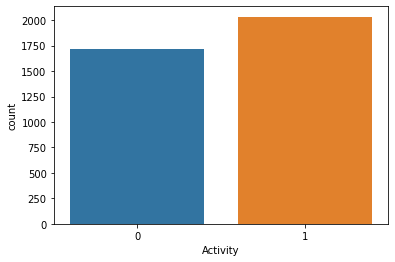

In [ ]:
train_act_graph = sns.countplot(x=train["Activity"])
#train_act_graph.set_xticklabels(train_act_graph.get_xticklabels())
plt.show()

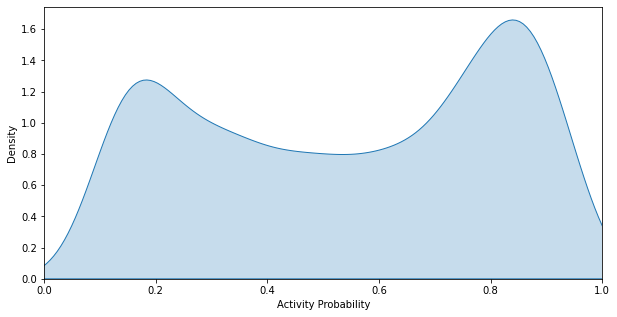

In [ ]:
plt.figure(figsize=(10,5)) 
plt.xlim(0,1) 
plt.xlabel('Activity Probability')
plt.ylabel('Density') 
test_act_graph = sns.kdeplot(x=test_activity["PredictedProbability"], shade = True)
plt.show()

In [ ]:
#https://plotly.com/python/pca-visualization/
#Visualize original dimension 
import plotly.express as px
fig = px.scatter_matrix(
    train,
    dimensions=train.iloc[:,1:10],
    color="Activity"
)
fig.update_traces(diagonal_visible=False)
fig.show()

             0
D27   0.472340
D87  -0.223081
D146  0.213311
D182  0.228664
D209  0.210154
D217 -0.233387
D469  0.268601
D596  0.204092
D607  0.210270
D659  0.226049
D660  0.204864
D747  0.226468


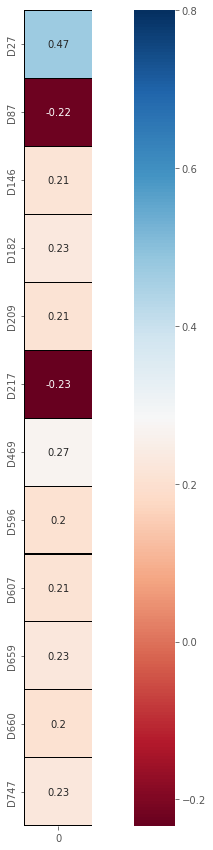

In [390]:
#Corrélation entre les variables et l'activité 
#corr =X_train[X_train.columns[1:]].corr(method='spearman')X_train[X_train.columns[0]]
corr = df_X_train.apply(lambda x: x.corr(df_y_train))
corr = pd.DataFrame(corr)
corr = corr.loc[abs(corr[0]) > 0.2]
print(corr)
plt.figure(figsize=(15,15))
sns.heatmap(corr, vmax = .8, linewidths = 0.01,square = True, annot = True, cmap = 'RdBu', linecolor = 'black')
#sn.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot= True)

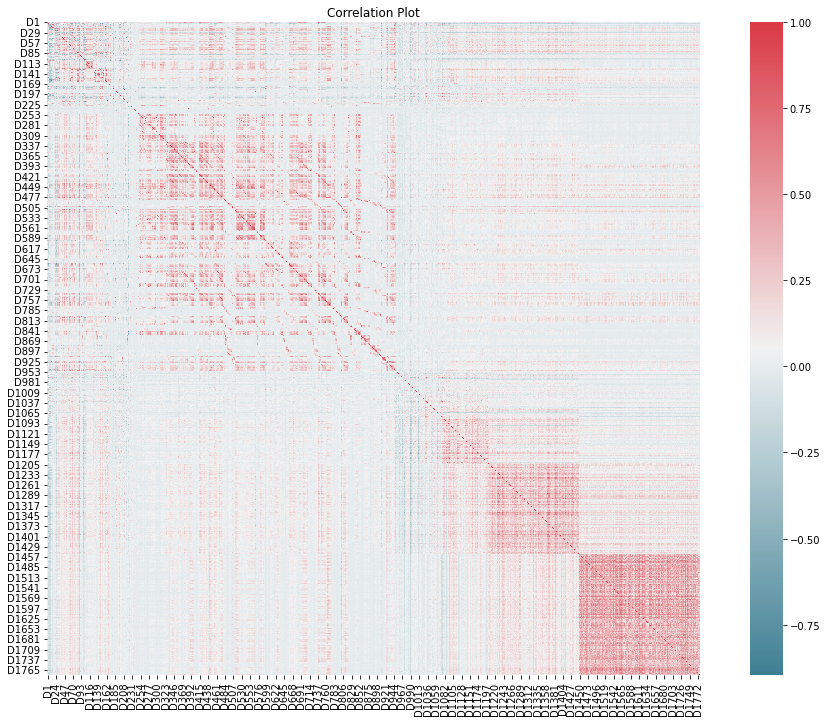

In [ ]:
# Corrélation entre les descripteurs
#https://www.kaggle.com/sociopath00/random-forest-using-gridsearchcv

cor= df_X_train.corr(method='pearson')
fig, ax =plt.subplots(figsize=(18, 12))
plt.title("Correlation Plot")
sns.heatmap(cor, mask=np.zeros_like(cor, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)
plt.show()

In [409]:
df1 = df_X_train.loc[:, 'D300':'D500']
df2 = df_X_train.loc[:, 'D944':'D1082']
df3 = df_X_train.loc[:, 'D1100':'D1150']
df3 = df_X_train.loc[:, 'D1300':'D1350']
df4 = df_X_train.loc[:, 'D1600':'D1650']
#df = df_X_train[['D1151','D1335', 'D1634']]
corr_X_train = pd.concat([df1,df2,df3,df4],axis = 1)
print(corr_X_train)
df1 = df_X_test.loc[:, 'D300':'D500']
df2 = df_X_test.loc[:, 'D944':'D1082']
df3 = df_X_test.loc[:, 'D1100':'D1150']
df3 = df_X_test.loc[:, 'D1300':'D1350']
df4 = df_X_test.loc[:, 'D1600':'D1650']
corr_X_test = pd.concat([df1,df2,df3,df4],axis = 1)


      D300  D301  D302  D303      D304  ...  D1646  D1647  D1648  D1649  D1650
0      0.0   0.0   0.0   0.0  0.000000  ...      0      0      0      0      0
1      0.0   0.0   0.0   0.0  0.000000  ...      0      0      1      1      0
2      0.0   0.0   0.0   0.0  0.000000  ...      0      0      0      0      0
3      0.0   0.0   0.0   0.0  0.000000  ...      0      0      0      0      0
4      0.0   0.0   0.0   0.0  0.000000  ...      0      0      0      0      0
...    ...   ...   ...   ...       ...  ...    ...    ...    ...    ...    ...
3746   0.0   0.0   0.0   0.0  0.000000  ...      0      0      0      0      0
3747   0.0   0.0   0.0   0.0  0.000000  ...      0      0      0      0      0
3748   0.0   0.0   0.0   0.0  0.000000  ...      0      0      0      0      0
3749   0.0   0.0   0.0   0.0  0.000000  ...      0      0      0      0      0
3750   0.0   0.0   0.0   0.0  0.666667  ...      0      0      0      0      0

[3751 rows x 442 columns]


# Preprocessing

In [412]:
minmax = MinMaxScaler()
scale_X_train = minmax.fit_transform(df_X_train)
scale_X_test = minmax.transform(df_X_test)
np_scale_X_test = minmax.transform(X_test)
np_scale_X_train = minmax.transform(X_train)
data_X_train = minmax.fit_transform(data_X_train)
data_X_valid = minmax.transform(data_X_valid)
print(df_X_train)
print(scale_X_train)


            D1        D2    D3   D4  ...  D1773  D1774  D1775  D1776
0     0.000000  0.497009  0.10  0.0  ...      0      0      0      0
1     0.366667  0.606291  0.05  0.0  ...      0      0      1      0
2     0.033300  0.480124  0.00  0.0  ...      0      0      0      0
3     0.000000  0.538825  0.00  0.5  ...      0      0      0      0
4     0.100000  0.517794  0.00  0.0  ...      0      0      0      0
...        ...       ...   ...  ...  ...    ...    ...    ...    ...
3746  0.033300  0.506409  0.10  0.0  ...      0      0      0      0
3747  0.133333  0.651023  0.15  0.0  ...      1      0      0      0
3748  0.200000  0.520564  0.00  0.0  ...      0      0      0      0
3749  0.100000  0.765646  0.00  0.0  ...      0      0      0      0
3750  0.133333  0.533952  0.00  0.0  ...      0      0      0      0

[3751 rows x 1776 columns]
[[0.         0.31495855 0.10526316 ... 0.         0.         0.        ]
 [0.36666667 0.47513728 0.05263158 ... 0.         1.         0.        

# Feature Selection

### A) Variance Threshold

In [385]:
from sklearn.feature_selection import VarianceThreshold
selector = VarianceThreshold(0.01)
select_X_train = selector.fit_transform(scale_X_train)
select_X_test = selector.transform(scale_X_test)
print(select_X_train.shape)
print(select_X_train)
print(select_X_test.shape)

(3751, 964)
[[0.31495855 0.         0.13066962 ... 0.         0.         0.        ]
 [0.47513728 0.         0.10886533 ... 0.         1.         0.        ]
 [0.29021004 0.         0.20770771 ... 0.         0.         0.        ]
 ...
 [0.34948349 0.         0.17778697 ... 0.         0.         0.        ]
 [0.70870849 0.         0.5357326  ... 0.         0.         0.        ]
 [0.369107   0.         0.34624665 ... 0.         0.         0.        ]]
(2501, 964)


### B) Kbest

     Descriptor       Score
0            D1   28.197757
1            D2   45.267204
2            D3  107.832861
3            D4    7.313876
4            D5   84.476080
...         ...         ...
1771      D1772    0.523618
1772      D1773    3.253320
1773      D1774    0.120508
1774      D1775    8.865198
1775      D1776    1.731779

[1776 rows x 2 columns]


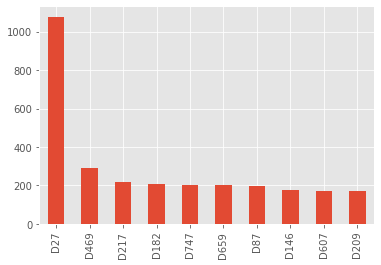

In [ ]:
#https://towardsdatascience.com/feature-selection-techniques-in-machine-learning-with-python-f24e7da3f36e
#Univariate feature selection works by selecting the best features based on univariate statistical tests.

#Regarde l'importance des descripteurs
kbest_features = SelectKBest(score_func=f_regression)
kbest_fit = kbest_features.fit(df_X_train,df_y_train)

dfscores = pd.DataFrame(kbest_fit.scores_)
dfcolumns = pd.DataFrame(df_X_train.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Descriptor','Score']  #naming the dataframe columns
print(featureScores)

best_features = pd.Series(kbest_fit.scores_, index=df_X_train.columns)
best_features.nlargest(10).plot(kind='bar')
plt.show()

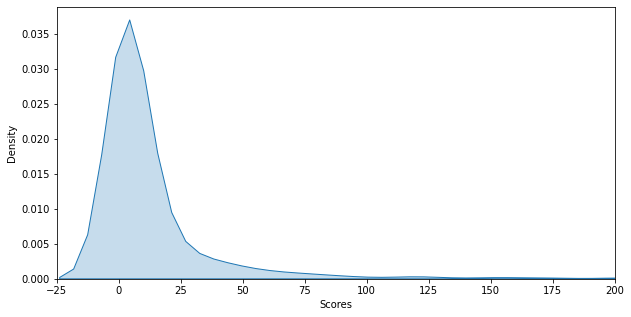

count    1.776000e+03
mean     1.294489e+01
std      3.543973e+01
min      6.151282e-07
25%      9.718127e-01
50%      4.319238e+00
75%      1.118902e+01
max      1.076620e+03
Name: Score, dtype: float64

In [ ]:
plt.figure(figsize=(10,5)) 
plt.xlim(-25,200) 
plt.xlabel('Scores')
plt.ylabel('Density') 
sns.kdeplot(x=featureScores["Score"], shade = True)
plt.show()
featureScores["Score"].describe()

In [ ]:
kbest_features = featureScores.loc[featureScores['Score'] > 11.2] #> 25 = 228 descripteurs restants
print(kbest_features) 
 
#print(bestFeatures)
#bestDescriptor = []
kbest_Descriptor = kbest_features['Descriptor'].tolist()

#print (bestDescriptor)

kbest_X_train = df_X_train.filter(items=kbest_Descriptor)
print(X_train_kbest)

kbest_X_test = df_X_test.filter(items=kbest_Descriptor)

     Descriptor       Score
0            D1   28.197757
1            D2   45.267204
2            D3  107.832861
4            D5   84.476080
5            D6   42.775793
...         ...         ...
1728      D1729   18.521387
1738      D1739   14.126535
1745      D1746   12.915126
1762      D1763   14.291980
1767      D1768   22.048653

[443 rows x 2 columns]
            D1        D2    D3        D5  ...  D1739  D1746  D1763  D1768
0     0.000000  0.497009  0.10  0.132956  ...      0      0      0      0
1     0.366667  0.606291  0.05  0.111209  ...      1      1      1      1
2     0.033300  0.480124  0.00  0.209791  ...      0      0      0      0
3     0.000000  0.538825  0.00  0.196344  ...      0      0      0      0
4     0.100000  0.517794  0.00  0.494734  ...      0      0      0      0
...        ...       ...   ...       ...  ...    ...    ...    ...    ...
3746  0.033300  0.506409  0.10  0.209887  ...      0      0      0      0
3747  0.133333  0.651023  0.15  0.151154  ...   

In [ ]:
kbest = SelectKBest(score_func=f_regression, k=443)
kbest_fit = kbest.fit_transform(X_train,y_train)
print(kbest_fit.shape)

(3751, 443)


### C) Extra trees

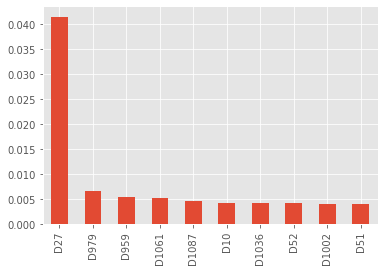

In [ ]:
#Tree-based feature selection
extra_trees = ExtraTreesClassifier()
extra_trees.fit(df_X_train,df_y_train)

#plot graph of feature importances for better visualization
feat_importances = pd.Series(extra_trees.feature_importances_, index=df_X_train.columns)
feat_importances.nlargest(10).plot(kind='bar')
plt.show()


     Descriptor  Importance
0            D1    0.001371
1            D2    0.002967
2            D3    0.001651
3            D4    0.000726
4            D5    0.002815
...         ...         ...
1771      D1772    0.000057
1772      D1773    0.000024
1773      D1774    0.000039
1774      D1775    0.000098
1775      D1776    0.000012

[1776 rows x 2 columns]


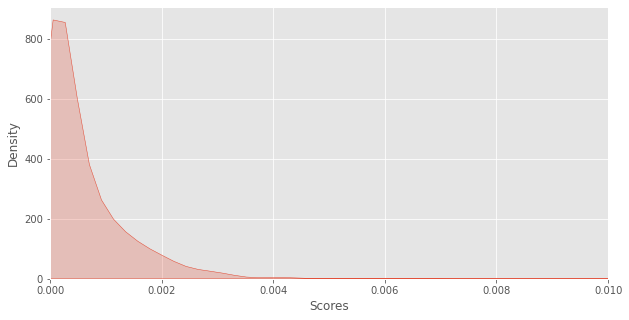

count    1776.000000
mean        0.000563
std         0.001208
min         0.000000
25%         0.000061
50%         0.000248
75%         0.000760
max         0.041480
Name: Importance, dtype: float64

In [ ]:
dfscores = pd.DataFrame(extra_trees.feature_importances_)
dfcolumns = pd.DataFrame(df_X_train.columns)
#concat two dataframes for better visualization 
featureImportances = pd.concat([dfcolumns,dfscores],axis=1)
featureImportances.columns = ['Descriptor','Importance']  #naming the dataframe columns
print(featureImportances)


plt.figure(figsize=(10,5)) 
plt.xlim(0,0.01) 
plt.xlabel('Scores')
plt.ylabel('Density') 
sns.kdeplot(x=featureImportances["Importance"], shade = True)
plt.show()
featureImportances["Importance"].describe()

In [ ]:
extra_trees_features = featureImportances.loc[featureImportances['Importance'] > 0.000786] #> 25 = 228 descripteurs restants
print(extra_trees_features) 
 
#print(bestFeatures)
#bestDescriptor = []
extra_trees_Descriptor = extra_trees_features['Descriptor'].tolist()

#print (bestDescriptor)

extra_trees_X_train = df_X_train.filter(items=extra_trees_Descriptor)
print(extra_trees_X_train)

extra_trees_X_test = df_X_test.filter(items=extra_trees_Descriptor)

     Descriptor  Importance
0            D1    0.001371
1            D2    0.002967
2            D3    0.001651
4            D5    0.002815
5            D6    0.002423
...         ...         ...
1337      D1338    0.000906
1340      D1341    0.000942
1389      D1390    0.001316
1425      D1426    0.000809
1433      D1434    0.001109

[431 rows x 2 columns]
            D1        D2    D3        D5  ...  D1341  D1390  D1426  D1434
0     0.000000  0.497009  0.10  0.132956  ...      0      0      0      0
1     0.366667  0.606291  0.05  0.111209  ...      0      1      1      0
2     0.033300  0.480124  0.00  0.209791  ...      0      0      0      0
3     0.000000  0.538825  0.00  0.196344  ...      0      0      0      0
4     0.100000  0.517794  0.00  0.494734  ...      0      0      0      0
...        ...       ...   ...       ...  ...    ...    ...    ...    ...
3746  0.033300  0.506409  0.10  0.209887  ...      0      0      0      0
3747  0.133333  0.651023  0.15  0.151154  ...   

In [ ]:
from sklearn.ensemble import ExtraTreesRegressor
extra_trees_reg = ExtraTreesRegressor(n_estimators=400, max_depth=20, random_state=0) #{'max_depth': 20, 'n_estimators': 400}
extra_trees_reg.fit(data_X_train, data_y_train)

extra_trees_train = extra_trees_reg.predict(data_X_train)
extra_trees_test = extra_trees_reg.predict(data_X_valid)
print(extra_trees_train)

extra_trees_train_loss = log_loss(data_y_train, extra_trees_train)
extra_trees_test_loss = log_loss(data_y_valid, extra_trees_test)
print(extra_trees_train_loss)
print(extra_trees_test_loss)

[0.01575497 0.08583809 0.99843443 ... 0.01057948 0.0269089  0.97947847]
0.03793895492875193
0.5134374081758137


In [ ]:
extra_trees_train.describe()

In [ ]:
#Lasso Regression, Random Forest 

### D) Gradient Boosting Regressor

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
gradient = GradientBoostingRegressor(n_estimators=400) #{'max_depth': 20, 'n_estimators': 400}
gradient.fit(data_X_train, data_y_train)

gradient_train = gradient.predict(data_X_train)
gradient_test = gradient.predict(data_X_valid)
print(gradient_train)

gradient_train_loss = log_loss(data_y_train, gradient_train)
gradient_test_loss = log_loss(data_y_valid, gradient_test)
print(gradient_train_loss)
print(gradient_test_loss)

[ 0.23086718  0.59883729  1.01417573 ...  0.23391794 -0.03476287
  0.94528058]
0.19743747828501002
0.6134795594461543


### E) Lasso


In [ ]:
from sklearn.linear_model import Lasso
lasso = Lasso()
lasso.fit(data_X_train, data_y_train)

lasso_train = gradient.predict(data_X_train)
lasso_test = gradient.predict(data_X_valid)
print(lasso_train)

lasso_train_loss = log_loss(data_y_train, lasso_train)
lasso_test_loss = log_loss(data_y_valid, lasso_test)
print(lasso_train_loss)
print(lasso_test_loss)

[ 0.23086718  0.59883729  1.01417573 ...  0.23391794 -0.03476287
  0.94528058]
0.19743747828501002
0.6224248469283115


### F) Random Forest

In [ ]:
#Random Forest , K-trees
from sklearn.ensemble import RandomForestRegressor
rforest = RandomForestRegressor(n_estimators=400, max_depth=20, random_state=0) #{'max_depth': 20, 'n_estimators': 400}
rforest.fit(data_X_train, data_y_train)
#print_accuracy(rforest.predict)

#https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/model_agnostic/Diabetes%20regression.html

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=20, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=400, n_jobs=None, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

In [ ]:
rfr_train = rforest.predict(data_X_train)
rfr_test = rforest.predict(data_X_valid)
print(rfr_train)

rfr_train_loss = log_loss(data_y_train, rfr_train)
rfr_test_loss = log_loss(data_y_valid, rfr_test)
print(rfr_train_loss)
print(rfr_test_loss)

[0.0539274  0.35581365 0.811447   ... 0.23496377 0.00732962 0.96717687]
0.13514252090956136
0.4878252442996781


In [119]:
df= pd.DataFrame(rfr_test)
df.describe()

,0
count,751.000000
mean,0.559792
std,0.320270
min,0.005371
25%,0.255000
50%,0.633707
75%,0.860864
max,0.984773


In [ ]:
#parameters = {'n_estimators' : [100,200,400], 'max_depth' : [5,10,20] }
param_grid = { 
    'n_estimators': [200,300, 400, 500,600],
    'max_features': ['sqrt', 'log2'],
    'max_depth' : [5,20,40],
    #'criterion' :['gini', 'entropy']
}
gridsearch = GridSearchCV(RandomForestRegressor(), param_grid)
gridsearch.fit(data_X_train, data_y_train)
print(gridsearch.best_params_)#best params 

SHAP du Random Forest 

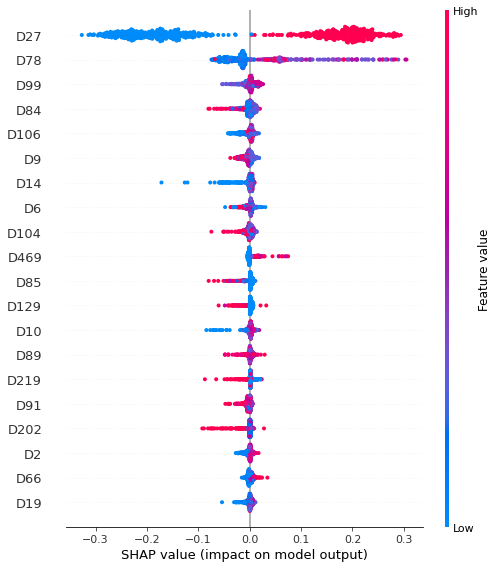

In [ ]:
explainer = shap.TreeExplainer(rforest)
shap_values = explainer.shap_values(data_X_valid)
shap.summary_plot(shap_values, data_X_valid)

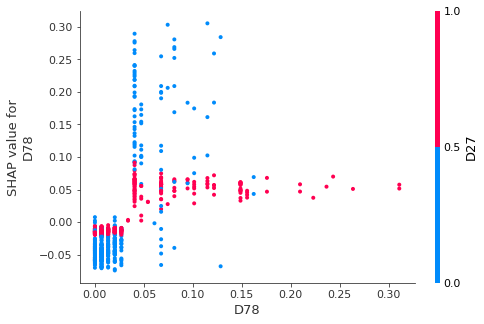

In [ ]:
shap.dependence_plot("D78", shap_values, data_X_valid)

# Dimensionality Reduction

### A) Principal Component Analysis

(3751, 350)


Text(0, 0.5, 'cumulative explained variance')

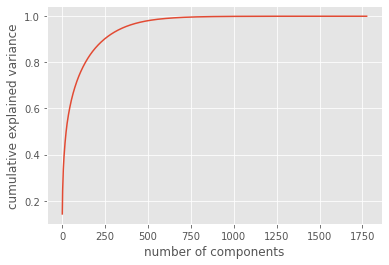

In [ ]:
#Dimensionality Reduction
#This is a high dimensional data set with too many dimensions. 
#Let's use PCA and t-sne to see if we can extract features
n_components = 350

#Let's look at the cumulative variance with repsect to the number of the components
pca_fit = PCA().fit(scale_X_train)
pca= PCA(n_components)
X_pca =pca.fit_transform(scale_X_train)
df_pca = pd.DataFrame(X_pca)
print (df_pca.shape)
pca_X_test = pca.transform(scale_X_test)

plt.plot(np.cumsum(pca_fit.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

#We need 500 components to describe 95 - 100 % of the variance


(0.0, 0.08)

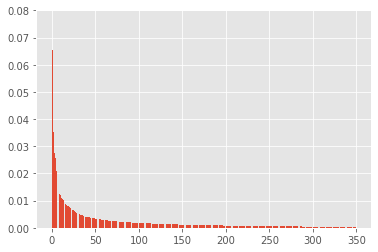

In [ ]:
#exp_var_pca = pca.explained_variance_ratio_
#plt.bar(range(0,len(exp_var_pca)), exp_var_pca, align='center', label='Individual explained variance')
#plt.ylim(0,0.08)

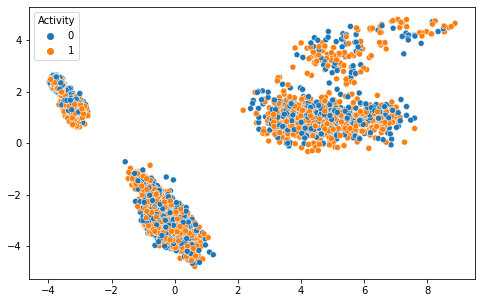

In [ ]:
#print(pca2.explained_variance_ratio_)
plt.figure(figsize=(8,5))
sns.scatterplot(
    x=X_pca[:,0], y=X_pca[:,1],
    hue=df_y_train,
    data=X_pca,
)
#print(df_var)
#sns.barplot(data=df_var, color="c");

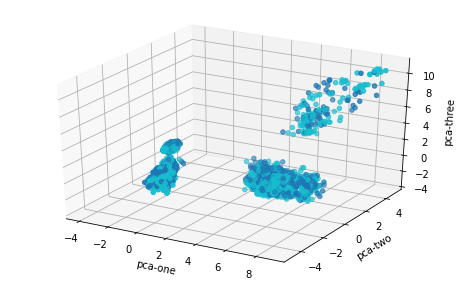

In [ ]:
ax = plt.figure(figsize=(8,5)).gca(projection='3d')
ax.scatter(
    xs=X_pca[:,0], 
    ys=X_pca[:,1], 
    zs=X_pca[:,2], 
    c=df_y_train, 
    cmap='tab10'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()

In [ ]:
labels = {
    str(i): f"PC{i+1} ({var:.1f})"
    for i, var in enumerate(pca.explained_variance_ratio_ * 100)
}

fig = px.scatter_matrix(
    X_pca,
    labels=labels,
    dimensions=range(5),
    color=train["Activity"]
)
fig.update_traces(diagonal_visible=True)
fig.show()

### B) T-SNE

[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 3751 samples in 0.721s...
[t-SNE] Computed neighbors for 3751 samples in 54.095s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3751
[t-SNE] Computed conditional probabilities for sample 2000 / 3751
[t-SNE] Computed conditional probabilities for sample 3000 / 3751
[t-SNE] Computed conditional probabilities for sample 3751 / 3751
[t-SNE] Mean sigma: 3.151570
[t-SNE] KL divergence after 250 iterations with early exaggeration: 68.920425
[t-SNE] KL divergence after 500 iterations: 0.828606


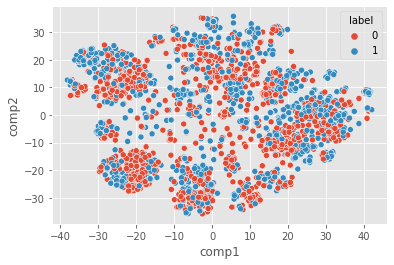

In [ ]:
from sklearn.manifold import TSNE

#T-SNE à partir de l'espace d'origine
tsne = TSNE(n_components=2, verbose=1, perplexity=100, n_iter=500)
tsne_results = tsne.fit_transform(df_X_train)

df_tsne = pd.DataFrame(tsne_results, columns=['comp1', 'comp2'])
df_tsne['label'] = df_y_train
sns.scatterplot(x='comp1', y='comp2', data=df_tsne, hue='label')

[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 3751 samples in 0.134s...
[t-SNE] Computed neighbors for 3751 samples in 10.813s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3751
[t-SNE] Computed conditional probabilities for sample 2000 / 3751
[t-SNE] Computed conditional probabilities for sample 3000 / 3751
[t-SNE] Computed conditional probabilities for sample 3751 / 3751
[t-SNE] Mean sigma: 3.137335
[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.563522
[t-SNE] KL divergence after 500 iterations: 0.788323


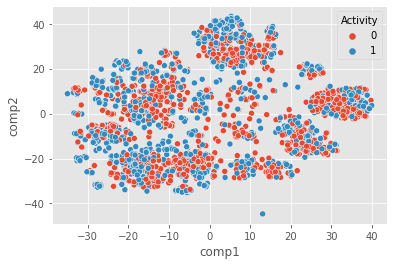

In [ ]:
from sklearn.manifold import TSNE
#https://towardsdatascience.com/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b
#T-SNE à partir de la PCA
tsne = TSNE(n_components=2, verbose=1, perplexity=100, n_iter=500)
tsne_X_train = tsne.fit_transform(X_pca)

df_tsne_pca = pd.DataFrame(tsne_X_train, columns=['comp1', 'comp2'])
#df_tsne_pca['label'] = df_y_train
sns.scatterplot(x='comp1', y='comp2', data=df_tsne_pca, hue=df_y_train)

[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 2501 samples in 0.442s...
[t-SNE] Computed neighbors for 2501 samples in 25.847s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2501
[t-SNE] Computed conditional probabilities for sample 2000 / 2501
[t-SNE] Computed conditional probabilities for sample 2501 / 2501
[t-SNE] Mean sigma: 3.251383
[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.321075
[t-SNE] KL divergence after 500 iterations: 0.792107


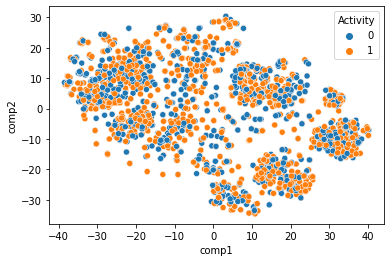

In [ ]:
tsne = TSNE(n_components=2, verbose=1, perplexity=100, n_iter=500)
tsne_X_test = tsne.fit_transform(scale_X_test)

df_tsne_pca = pd.DataFrame(tsne_X_test, columns=['comp1', 'comp2'])
#df_tsne_pca['label'] = df_y_train
sns.scatterplot(x='comp1', y='comp2', data=df_tsne_pca, hue=df_y_train)

### C) MDS

In [ ]:
#https://medium.com/dataseries/multidimensional-scaling-for-dissimilarity-visualization-9fb061396cf3
#MDS : visualisation
#dis_matrix = pairwise_distances(X_train, metric = 'jaccard')
#print(dis_matrix.shape)
mds = MDS(n_components=2)
X_mds = mds.fit_transform(scale_X_train)
print(X_mds)
print(X_mds.shape)

[[  0.62749128   3.63720042]
 [  1.70170278 -17.83482394]
 [ -2.18299237   2.51664266]
 ...
 [  8.5907974    7.40863316]
 [ -4.06161289   7.80390782]
 [ -6.42048099   4.91931792]]
(3751, 2)


In [ ]:
X_test_mds = mds.fit_transform(scale_X_test)

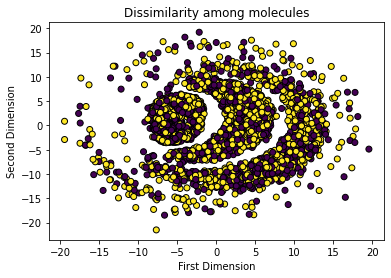

In [ ]:
plt.figure()
plt.scatter(X_mds[:,0],X_mds[:,1],facecolors = 'black', edgecolors = 'black', c=df_y_train)  # points in white (invisible)
labels = df_X_train.columns
#for label, x, y in zip(labels, X_transformed[:,0], X_transformed[:,1]):
    #plt.annotate(label, (x,y), xycoords = 'data')
plt.xlabel('First Dimension')
plt.ylabel('Second Dimension')
plt.title('Dissimilarity among molecules')    
plt.show()

ValueError: ignored

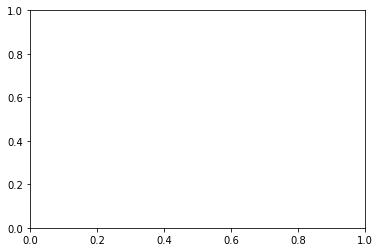

In [ ]:
#https://stackabuse.com/guide-to-multidimensional-scaling-in-python-with-scikit-learn/
#Suivi du stress en fonction des dimensions du MDS
from sklearn.metrics.pairwise import manhattan_distances, euclidean_distances
dist_euclid = euclidean_distances(df_X_train)
stress = []
# Max value for n_components
max_range = 10
for dim in range(2, max_range):
    # Set up the MDS object
    mds = MDS(n_components=dim, dissimilarity='precomputed', random_state=0)
    # Apply MDS
    pts = mds.fit_transform(df_X_train)
    # Retrieve the stress value
    stress.append(mds.stress_)
# Plot stress vs. n_components    
plt.plot(range(2, max_range), stress)
plt.xticks(range(2, max_range, 2))
plt.xlabel('n_components')
plt.ylabel('stress')
plt.show()

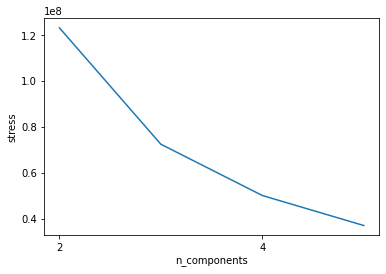

In [ ]:
# Plot stress vs. n_components    
plt.plot(range(2, max_range), stress)
plt.xticks(range(2, max_range, 2))
plt.xlabel('n_components')
plt.ylabel('stress')
plt.show()

# Machine Learning model

### Modèle à partir de l'espace d'origine

In [376]:
#Input of the model
input_shape = (1776,) #1776 descriptors
inputs = keras.Input(shape=input_shape)
print(inputs.shape)
print(inputs.dtype)
#drop_out_1 = layers.Dropout(0.2)(inputs)
#Model layers
hidden1 = layers.Dense(64, activation="relu")(inputs)
hidden2 = layers.Dense(32, activation="relu")(hidden1)

#hidden3 = layers.Dense(32, activation="relu")(hidden2)# 3755 1 hidden
outputs = layers.Dense(1, activation ="sigmoid")(hidden2) #shape = 1 -> One value between 0 and 1 (regression)
model = keras.Model(inputs=inputs, outputs=outputs,name="bioresponse_model")


(None, 1559)
<dtype: 'float32'>


In [343]:
#Compile model
#Binary Cross-Entropy specifies that the model should optimize the log loss
model.compile(
    #loss=keras.losses.MeanSquaredError(),
    loss=tf.keras.losses.BinaryCrossentropy(), #Evaluate the model with the log loss 
    optimizer=keras.optimizers.SGD(), #ou Adagrad avec haut LR
    #metrics=[soft_acc] #Compute accuracy for a regression model
    metrics=["accuracy"]
)

In [344]:
histori=model.fit(scale_X_train,df_y_train, batch_size=75, epochs= 50, validation_split=0.2)

Epoch 1/50
40/40 [==============================] - 1s 13ms/step - loss: 0.6882 - accuracy: 0.5313 - val_loss: 0.6882 - val_accuracy: 0.5260
Epoch 2/50
40/40 [==============================] - 0s 5ms/step - loss: 0.6788 - accuracy: 0.5550 - val_loss: 0.6821 - val_accuracy: 0.5393
Epoch 3/50
40/40 [==============================] - 0s 5ms/step - loss: 0.6700 - accuracy: 0.5690 - val_loss: 0.6749 - val_accuracy: 0.5593
Epoch 4/50
40/40 [==============================] - 0s 5ms/step - loss: 0.6596 - accuracy: 0.6037 - val_loss: 0.6663 - val_accuracy: 0.6032
Epoch 5/50
40/40 [==============================] - 0s 5ms/step - loss: 0.6482 - accuracy: 0.6390 - val_loss: 0.6564 - val_accuracy: 0.6112
Epoch 6/50
40/40 [==============================] - 0s 5ms/step - loss: 0.6361 - accuracy: 0.6587 - val_loss: 0.6456 - val_accuracy: 0.6245
Epoch 7/50
40/40 [==============================] - 0s 6ms/step - loss: 0.6226 - accuracy: 0.6810 - val_loss: 0.6365 - val_accuracy: 0.6298
Epoch 8/50
40/40 [=

In [ ]:
model.summary()

Model: "bioresponse_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 1776)]            0         
_________________________________________________________________
dense_8 (Dense)              (None, 64)                113728    
_________________________________________________________________
dense_9 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 65        
Total params: 117,953
Trainable params: 117,953
Non-trainable params: 0
_________________________________________________________________


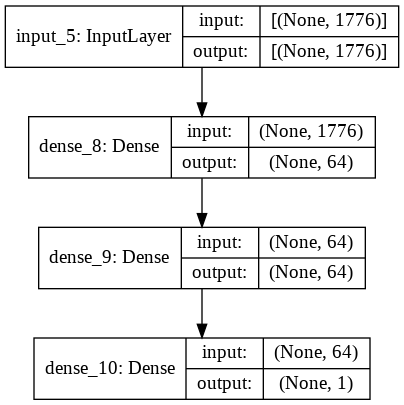

In [ ]:
keras.utils.plot_model(model, "my_first_model_show_shape.png", show_shapes=True)

In [ ]:
#https://stackoverflow.com/questions/42665359/how-do-you-compute-accuracy-in-a-regression-model-after-rounding-predictions-to
from keras import backend as K

def soft_acc(y_true, y_pred):
    return K.mean(K.equal(K.round(y_true), K.round(y_pred)))

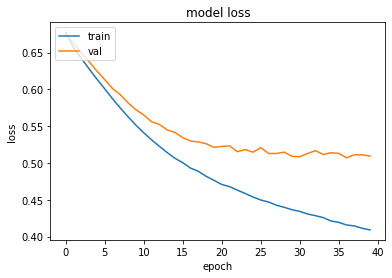

In [ ]:
#Summarize history for loss
plt.plot(histori.history['loss'])
plt.plot(histori.history['val_loss'])
plt.title ('model loss')
plt.ylabel ('loss')
plt.xlabel ('epoch')
plt.legend (['train', 'val'], loc = 'upper left')
plt.show()

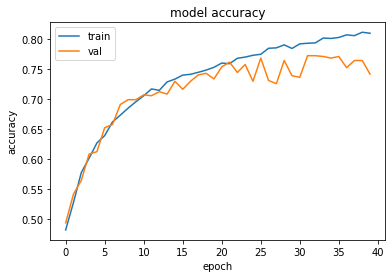

In [ ]:
#Summarize history for accuracy
plt.plot(histori.history['accuracy'])
plt.plot(histori.history['val_accuracy'])
plt.title ('model accuracy')
plt.ylabel ('accuracy')
plt.xlabel ('epoch')
plt.legend (['train', 'val'], loc = 'upper left')
plt.show()

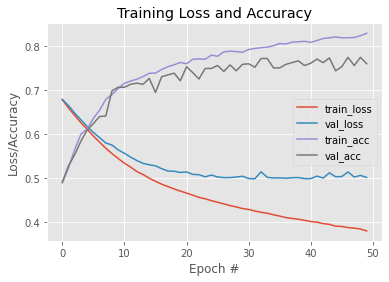

In [ ]:
# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 50), histori.history["loss"], label="train_loss")
plt.plot(np.arange(0, 50), histori.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, 50), histori.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, 50), histori.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

In [345]:
#Test the model
loss, acc = model.evaluate(df_X_test, df_y_test, verbose=1)
print(loss)

79/79 [==============================] - 0s 2ms/step - loss: 0.5836 - accuracy: 0.0000e+00
0.5836371779441833


In [349]:
predict_model = model.predict(df_X_test)
print(pd.DataFrame(predict_model).describe())

                 0
count  2501.000000
mean      0.536485
std       0.323919
min       0.012762
25%       0.198005
50%       0.590754
75%       0.841109
max       0.998798


### Modèle à partir des descripteurs filtrées par leur variance

In [386]:
#Input of the model
input_shape = (select_X_train.shape[1],) 
inputs = keras.Input(shape=input_shape)
#drop_out_1 = layers.Dropout(0.2)(inputs)
#Model layers
hidden1 = layers.Dense(64, activation="relu")(inputs)
hidden2 = layers.Dense(32, activation="relu")(hidden1)

#hidden3 = layers.Dense(32, activation="relu")(hidden2)# 3755 1 hidden
outputs = layers.Dense(1, activation ="sigmoid")(hidden2) #shape = 1 -> One value between 0 and 1 (regression)

model_var = keras.Model(inputs=inputs, outputs=outputs,name="model_kbest")
#Compile model
#Binary Cross-Entropy specifies that the model should optimize the log loss
model_var.compile(
    #loss=keras.losses.MeanSquaredError(),
    loss=tf.keras.losses.BinaryCrossentropy(), #Evaluate the model with the log loss 
    optimizer=keras.optimizers.SGD(learning_rate=0.01), #ou Adagrad avec haut LR
    metrics=["accuracy"]
)
history_model_var=model_var.fit(select_X_train,df_y_train, batch_size=75, epochs= 50, validation_split=0.2)

Epoch 1/50
40/40 [==============================] - 1s 8ms/step - loss: 0.6932 - accuracy: 0.5107 - val_loss: 0.6839 - val_accuracy: 0.5379
Epoch 2/50
40/40 [==============================] - 0s 6ms/step - loss: 0.6711 - accuracy: 0.5687 - val_loss: 0.6718 - val_accuracy: 0.5779
Epoch 3/50
40/40 [==============================] - 0s 5ms/step - loss: 0.6556 - accuracy: 0.6163 - val_loss: 0.6594 - val_accuracy: 0.6298
Epoch 4/50
40/40 [==============================] - 0s 5ms/step - loss: 0.6415 - accuracy: 0.6543 - val_loss: 0.6480 - val_accuracy: 0.6458
Epoch 5/50
40/40 [==============================] - 0s 4ms/step - loss: 0.6276 - accuracy: 0.6753 - val_loss: 0.6355 - val_accuracy: 0.6565
Epoch 6/50
40/40 [==============================] - 0s 4ms/step - loss: 0.6139 - accuracy: 0.6907 - val_loss: 0.6236 - val_accuracy: 0.6684
Epoch 7/50
40/40 [==============================] - 0s 4ms/step - loss: 0.5996 - accuracy: 0.7050 - val_loss: 0.6112 - val_accuracy: 0.6631
Epoch 8/50
40/40 [==

79/79 [==============================] - 0s 2ms/step - loss: 0.5872 - accuracy: 0.0000e+00
0.5872410535812378


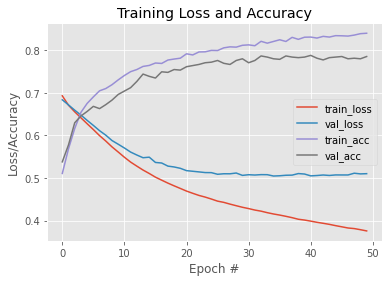

In [387]:
# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(history_model_var.history["loss"], label="train_loss")
plt.plot(history_model_var.history["val_loss"], label="val_loss")
plt.plot(history_model_var.history["accuracy"], label="train_acc")
plt.plot(history_model_var.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
#Test the model
loss, acc = model_var.evaluate(select_X_test, df_y_test, verbose=1)
print(loss)

### Modèle à partir de groupes de descripteurs corrélés

In [408]:
#Input of the model
input_shape = (corr_X_train.shape[1],) 
inputs = keras.Input(shape=input_shape)
#drop_out_1 = layers.Dropout(0.2)(inputs)
#Model layers
hidden1 = layers.Dense(64, activation="relu")(inputs)
hidden2 = layers.Dense(32, activation="relu")(hidden1)

#hidden3 = layers.Dense(32, activation="relu")(hidden2)# 3755 1 hidden
outputs = layers.Dense(1, activation ="sigmoid")(hidden2) #shape = 1 -> One value between 0 and 1 (regression)

model_corr = keras.Model(inputs=inputs, outputs=outputs,name="model_kbest")
#Compile model
#Binary Cross-Entropy specifies that the model should optimize the log loss
model_corr.compile(
    #loss=keras.losses.MeanSquaredError(),
    loss=tf.keras.losses.BinaryCrossentropy(), #Evaluate the model with the log loss 
    optimizer=keras.optimizers.SGD(learning_rate=0.01), #ou Adagrad avec haut LR
    metrics=["accuracy"]
)
history_model_corr=model_corr.fit(corr_X_train,df_y_train, batch_size=50, epochs= 100, validation_split=0.2)

Epoch 1/100
60/60 [==============================] - 1s 8ms/step - loss: 0.7105 - accuracy: 0.4990 - val_loss: 0.6885 - val_accuracy: 0.5020
Epoch 2/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6790 - accuracy: 0.5547 - val_loss: 0.6786 - val_accuracy: 0.5593
Epoch 3/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6679 - accuracy: 0.5920 - val_loss: 0.6704 - val_accuracy: 0.5792
Epoch 4/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6578 - accuracy: 0.6123 - val_loss: 0.6621 - val_accuracy: 0.5885
Epoch 5/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6477 - accuracy: 0.6343 - val_loss: 0.6533 - val_accuracy: 0.6099
Epoch 6/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6374 - accuracy: 0.6507 - val_loss: 0.6466 - val_accuracy: 0.6205
Epoch 7/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6275 - accuracy: 0.6623 - val_loss: 0.6391 - val_accuracy: 0.6365
Epoch 8/100
6

79/79 [==============================] - 0s 2ms/step - loss: 0.6589 - accuracy: 0.0000e+00
0.6589276790618896


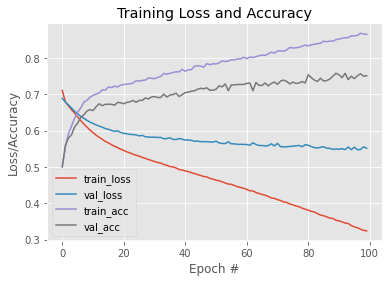

In [411]:
# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(history_model_corr.history["loss"], label="train_loss")
plt.plot(history_model_corr.history["val_loss"], label="val_loss")
plt.plot(history_model_corr.history["accuracy"], label="train_acc")
plt.plot(history_model_corr.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
#Test the model
loss, acc = model_corr.evaluate(corr_X_test, df_y_test, verbose=1)
print(loss)

### Modèle à partir des Kbest descripteurs

In [ ]:
#Input of the model
input_shape = (443,) 
inputs = keras.Input(shape=input_shape)
#drop_out_1 = layers.Dropout(0.2)(inputs)
#Model layers
hidden1 = layers.Dense(64, activation="relu")(inputs)
hidden2 = layers.Dense(32, activation="relu")(hidden1)

#hidden3 = layers.Dense(32, activation="relu")(hidden2)# 3755 1 hidden
outputs = layers.Dense(1, activation ="sigmoid")(hidden2) #shape = 1 -> One value between 0 and 1 (regression)

model_kbest = keras.Model(inputs=inputs, outputs=outputs,name="model_kbest")
#Compile model
#Binary Cross-Entropy specifies that the model should optimize the log loss
model_kbest.compile(
    #loss=keras.losses.MeanSquaredError(),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), #Evaluate the model with the log loss 
    optimizer=keras.optimizers.SGD(learning_rate=0.01), #ou Adagrad avec haut LR
    #metrics=[soft_acc] #Compute accuracy for a regression model
    metrics=["accuracy"]
)
history_model_kbest=model_kbest.fit(kbest_X_train,df_y_train, batch_size=75, epochs= 50, validation_split=0.2)

Epoch 1/50
40/40 [==============================] - 1s 9ms/step - loss: 0.7118 - accuracy: 0.4610 - val_loss: 0.6938 - val_accuracy: 0.4647
Epoch 2/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6743 - accuracy: 0.4917 - val_loss: 0.6831 - val_accuracy: 0.4874
Epoch 3/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6638 - accuracy: 0.5417 - val_loss: 0.6759 - val_accuracy: 0.5047
Epoch 4/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6547 - accuracy: 0.5553 - val_loss: 0.6691 - val_accuracy: 0.5366
Epoch 5/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6461 - accuracy: 0.5690 - val_loss: 0.6616 - val_accuracy: 0.5353
Epoch 6/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6370 - accuracy: 0.5857 - val_loss: 0.6535 - val_accuracy: 0.5459
Epoch 7/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6276 - accuracy: 0.5970 - val_loss: 0.6450 - val_accuracy: 0.5593
Epoch 8/50
40/40 [==

79/79 [==============================] - 0s 2ms/step - loss: 0.5591 - accuracy: 0.0000e+00
0.5591301321983337


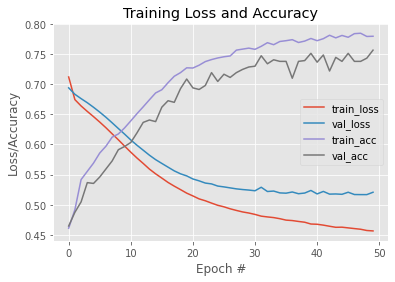

In [ ]:
# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 50), history_model_kbest.history["loss"], label="train_loss")
plt.plot(np.arange(0, 50), history_model_kbest.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, 50), history_model_kbest.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, 50), history_model_kbest.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
#Test the model
loss, acc = model_kbest.evaluate(kbest_X_test, df_y_test, verbose=1)
print(loss)

### (Modèle à partir des Extra Trees descripteurs)

In [ ]:
#Input of the model
input_shape = (431,) 
inputs = keras.Input(shape=input_shape)
print(inputs.shape)
print(inputs.dtype)
#drop_out_1 = layers.Dropout(0.2)(inputs)
#Model layers
hidden1 = layers.Dense(64, activation="relu")(inputs)
hidden2 = layers.Dense(32, activation="relu")(hidden1)

#hidden3 = layers.Dense(32, activation="relu")(hidden2)# 3755 1 hidden
outputs = layers.Dense(1, activation ="sigmoid")(hidden2) #shape = 1 -> One value between 0 and 1 (regression)
model_extra_trees = keras.Model(inputs=inputs, outputs=outputs,name="model_extra_trees")
#Compile model
#Binary Cross-Entropy specifies that the model should optimize the log loss
model_extra_trees.compile(
    #loss=keras.losses.MeanSquaredError(),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), #Evaluate the model with the log loss 
    optimizer=keras.optimizers.SGD(), #ou Adagrad avec haut LR
    metrics=["accuracy"]
)
history_model_extra_trees=model_extra_trees.fit(extra_trees_X_train,df_y_train, batch_size=75, epochs= 60, validation_split=0.2)

(None, 431)
<dtype: 'float32'>
Epoch 1/60
40/40 [==============================] - 1s 16ms/step - loss: 0.7407 - accuracy: 0.4563 - val_loss: 0.7024 - val_accuracy: 0.4634
Epoch 2/60
40/40 [==============================] - 0s 3ms/step - loss: 0.6881 - accuracy: 0.4580 - val_loss: 0.6881 - val_accuracy: 0.4634
Epoch 3/60
40/40 [==============================] - 0s 3ms/step - loss: 0.6758 - accuracy: 0.4663 - val_loss: 0.6792 - val_accuracy: 0.4647
Epoch 4/60
40/40 [==============================] - 0s 3ms/step - loss: 0.6657 - accuracy: 0.4827 - val_loss: 0.6712 - val_accuracy: 0.4860
Epoch 5/60
40/40 [==============================] - 0s 3ms/step - loss: 0.6561 - accuracy: 0.5197 - val_loss: 0.6625 - val_accuracy: 0.5047
Epoch 6/60
40/40 [==============================] - 0s 3ms/step - loss: 0.6462 - accuracy: 0.5543 - val_loss: 0.6533 - val_accuracy: 0.5353
Epoch 7/60
40/40 [==============================] - 0s 3ms/step - loss: 0.6360 - accuracy: 0.5753 - val_loss: 0.6446 - val_accur

79/79 [==============================] - 0s 1ms/step - loss: 0.7422 - accuracy: 0.0000e+00
0.7421627044677734


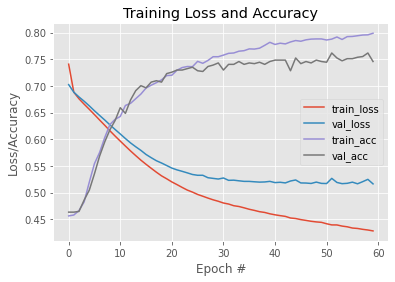

In [ ]:
# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 60), history_model_extra_trees.history["loss"], label="train_loss")
plt.plot(np.arange(0, 60), history_model_extra_trees.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, 60), history_model_extra_trees.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, 60), history_model_extra_trees.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
#Test the model
loss, acc = model_acp.evaluate(df_pca_test, df_y_test, verbose=1)
print(loss)

### Modèle à partir des composants principaux de l'ACP

In [ ]:
#Input of the model
input_shape = (350,) 
inputs = keras.Input(shape=input_shape)
print(inputs.shape)
print(inputs.dtype)
#drop_out_1 = layers.Dropout(0.2)(inputs)
#Model layers
hidden1 = layers.Dense(64, activation="relu")(inputs)
hidden2 = layers.Dense(32, activation="relu")(hidden1)

#hidden3 = layers.Dense(32, activation="relu")(hidden2)# 3755 1 hidden
outputs = layers.Dense(1, activation ="sigmoid")(hidden2) #shape = 1 -> One value between 0 and 1 (regression)

model_acp = keras.Model(inputs=inputs, outputs=outputs,name="bioresponse_model")
#Compile model
#Binary Cross-Entropy specifies that the model should optimize the log loss
model_acp.compile(
    #loss=keras.losses.MeanSquaredError(),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), #Evaluate the model with the log loss 
    optimizer=keras.optimizers.SGD(), #ou Adagrad avec haut LR
    metrics=["accuracy"]
)
history_model_acp=model_acp.fit(X_pca,df_y_train, batch_size=75, epochs= 70, validation_split=0.2)

(None, 350)
<dtype: 'float32'>
Epoch 1/70
40/40 [==============================] - 1s 6ms/step - loss: 0.6905 - accuracy: 0.4993 - val_loss: 0.6979 - val_accuracy: 0.4847
Epoch 2/70
40/40 [==============================] - 0s 3ms/step - loss: 0.6785 - accuracy: 0.5183 - val_loss: 0.6881 - val_accuracy: 0.5007
Epoch 3/70
40/40 [==============================] - 0s 3ms/step - loss: 0.6681 - accuracy: 0.5263 - val_loss: 0.6794 - val_accuracy: 0.5140
Epoch 4/70
40/40 [==============================] - 0s 3ms/step - loss: 0.6588 - accuracy: 0.5383 - val_loss: 0.6714 - val_accuracy: 0.5353
Epoch 5/70
40/40 [==============================] - 0s 3ms/step - loss: 0.6503 - accuracy: 0.5563 - val_loss: 0.6641 - val_accuracy: 0.5459
Epoch 6/70
40/40 [==============================] - 0s 3ms/step - loss: 0.6422 - accuracy: 0.5733 - val_loss: 0.6572 - val_accuracy: 0.5566
Epoch 7/70
40/40 [==============================] - 0s 3ms/step - loss: 0.6346 - accuracy: 0.5897 - val_loss: 0.6506 - val_accura

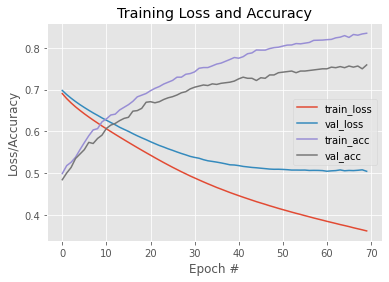

In [ ]:
# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 70), history_model_acp.history["loss"], label="train_loss")
plt.plot(np.arange(0, 70), history_model_acp.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, 70), history_model_acp.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, 70), history_model_acp.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

In [ ]:
#Test the model
loss, acc = model_acp.evaluate(df_pca_test, df_y_test, verbose=1)
print(loss)

79/79 [==============================] - 0s 2ms/step - loss: 0.5967 - accuracy: 0.0000e+00
0.5967131853103638


### Modèle à partir du MDS

In [ ]:
#Input of the model
input_shape = (2,) 
inputs = keras.Input(shape=input_shape)
print(inputs.shape)
print(inputs.dtype)
#drop_out_1 = layers.Dropout(0.2)(inputs)
#Model layers
hidden1 = layers.Dense(64, activation="relu")(inputs)
hidden2 = layers.Dense(32, activation="relu")(hidden1)

#hidden3 = layers.Dense(32, activation="relu")(hidden2)# 3755 1 hidden
outputs = layers.Dense(1, activation ="sigmoid")(hidden2) #shape = 1 -> One value between 0 and 1 (regression)

model_mds = keras.Model(inputs=inputs, outputs=outputs,name="model_mds")
#Compile model
#Binary Cross-Entropy specifies that the model should optimize the log loss
model_mds.compile(
    #loss=keras.losses.MeanSquaredError(),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), #Evaluate the model with the log loss 
    optimizer=keras.optimizers.SGD(learning_rate=0.01), #ou Adagrad avec haut LR
    #metrics=[soft_acc] #Compute accuracy for a regression model
    metrics=["accuracy"]
)
history_model_mds=model_mds.fit(X_mds,df_y_train, batch_size=75, epochs= 50, validation_split=0.2)

(None, 2)
<dtype: 'float32'>
Epoch 1/50
40/40 [==============================] - 1s 9ms/step - loss: 0.6926 - accuracy: 0.4867 - val_loss: 0.6962 - val_accuracy: 0.4940
Epoch 2/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6774 - accuracy: 0.5050 - val_loss: 0.6920 - val_accuracy: 0.4794
Epoch 3/50
40/40 [==============================] - 0s 5ms/step - loss: 0.6747 - accuracy: 0.5027 - val_loss: 0.6897 - val_accuracy: 0.4767
Epoch 4/50
40/40 [==============================] - 0s 4ms/step - loss: 0.6732 - accuracy: 0.5067 - val_loss: 0.6869 - val_accuracy: 0.4780
Epoch 5/50
40/40 [==============================] - 0s 4ms/step - loss: 0.6718 - accuracy: 0.5030 - val_loss: 0.6922 - val_accuracy: 0.4820
Epoch 6/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6718 - accuracy: 0.5117 - val_loss: 0.6863 - val_accuracy: 0.4794
Epoch 7/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6719 - accuracy: 0.5037 - val_loss: 0.6878 - val_accuracy

In [ ]:
# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 50), history_model_mds.history["loss"], label="train_loss")
plt.plot(np.arange(0, 50), history_model_mds.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, 50), history_model_mds.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, 50), history_model_mds.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
#Test the model
loss, acc = model_mds.evaluate(, df_y_test, verbose=1)
print(loss)

NameError: ignored

<Figure size 432x288 with 0 Axes>

### Modèle à partir du T-SNE

In [ ]:
#Input of the model
input_shape = (2,) 
inputs = keras.Input(shape=input_shape)
print(inputs.shape)
print(inputs.dtype)
#drop_out_1 = layers.Dropout(0.2)(inputs)
#Model layers
hidden1 = layers.Dense(64, activation="relu")(inputs)
hidden2 = layers.Dense(32, activation="relu")(hidden1)

#hidden3 = layers.Dense(32, activation="relu")(hidden2)# 3755 1 hidden
outputs = layers.Dense(1, activation ="sigmoid")(hidden2) #shape = 1 -> One value between 0 and 1 (regression)

model_tsne = keras.Model(inputs=inputs, outputs=outputs,name="model_mds")
#Compile model
#Binary Cross-Entropy specifies that the model should optimize the log loss
model_tsne.compile(
    #loss=keras.losses.MeanSquaredError(),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), #Evaluate the model with the log loss 
    optimizer=keras.optimizers.SGD(learning_rate=0.01), #ou Adagrad avec haut LR
    #metrics=[soft_acc] #Compute accuracy for a regression model
    metrics=["accuracy"]
)
history_model_tsne=model_tsne.fit(tsne_X_train,df_y_train, batch_size=75, epochs= 50, validation_split=0.2)

(None, 2)
<dtype: 'float32'>
Epoch 1/50
40/40 [==============================] - 1s 6ms/step - loss: 0.7028 - accuracy: 0.5260 - val_loss: 0.6900 - val_accuracy: 0.5073
Epoch 2/50
40/40 [==============================] - 0s 2ms/step - loss: 0.6739 - accuracy: 0.5370 - val_loss: 0.6883 - val_accuracy: 0.5113
Epoch 3/50
40/40 [==============================] - 0s 2ms/step - loss: 0.6768 - accuracy: 0.5410 - val_loss: 0.6799 - val_accuracy: 0.5526
Epoch 4/50
40/40 [==============================] - 0s 2ms/step - loss: 0.6775 - accuracy: 0.5493 - val_loss: 0.6925 - val_accuracy: 0.5406
Epoch 5/50
40/40 [==============================] - 0s 2ms/step - loss: 0.6707 - accuracy: 0.5480 - val_loss: 0.6930 - val_accuracy: 0.5646
Epoch 6/50
40/40 [==============================] - 0s 2ms/step - loss: 0.6700 - accuracy: 0.5600 - val_loss: 0.6719 - val_accuracy: 0.5739
Epoch 7/50
40/40 [==============================] - 0s 2ms/step - loss: 0.6710 - accuracy: 0.5397 - val_loss: 0.6728 - val_accuracy

79/79 [==============================] - 0s 2ms/step - loss: 0.7611 - accuracy: 0.0000e+00
0.7610737681388855


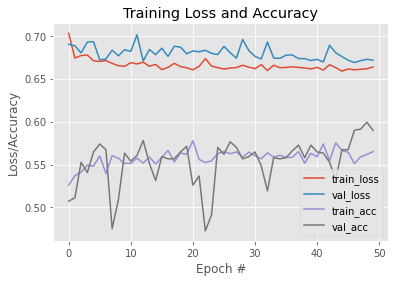

In [ ]:
# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 50), history_model_tsne.history["loss"], label="train_loss")
plt.plot(np.arange(0, 50), history_model_tsne.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, 50), history_model_tsne.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, 50), history_model_tsne.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
#Test the model
loss, acc = model_tsne.evaluate(tsne_X_test, df_y_test, verbose=1)
print(loss)

# Auto-Encoder

In [ ]:
#Auto-encoder :
#Standardisations des variables
std = MinMaxScaler()
#Z = std.fit_transform(df_X_train) #version df
#Z = pd.DataFrame(Z)
#print(Z)
#print(Z.shape)
Z2 = std.fit_transform(X_train) #version array

In [315]:
#Auto-Encodeur modèle http://eric.univ-lyon2.fr/~ricco/tanagra/fichiers/fr_Tanagra_Keras_Autoencoder.pdf
input_shape = (1776,) #1776 descriptors
inputsL = keras.Input(shape=input_shape)

#Model layers
hiddenL = layers.Dense(2,activation='sigmoid')(inputsL) #activity_regularizer=regularizers.l1(10e-6)
outputL = layers.Dense(1776,activation='linear')(hiddenL)

model_ae = keras.Model(inputs=inputsL, outputs=outputL,name="auto_encoder_model")

model_ae.compile(
    #loss=keras.losses.BinaryCrossentropy(),
    loss=keras.losses.MeanSquaredError(),
    #loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), #Evaluate the model with the log loss 
    optimizer=keras.optimizers.Adam(), #ou Adagrad avec haut LR
    #metrics=[soft_acc] #Compute accuracy for a regression model

)

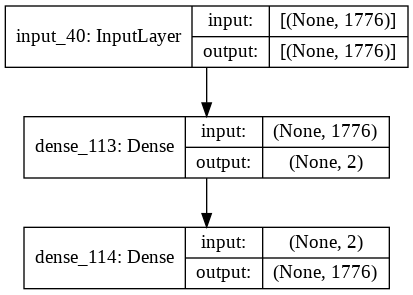

In [249]:
keras.utils.plot_model(model_ae, "my_first_model_show_shape.png", show_shapes=True)

In [316]:
#Entrainement
histori_ae=model_ae.fit(scale_X_train,df_y_train, batch_size=75, epochs= 50, validation_split=0.2)

Epoch 1/50
40/40 [==============================] - 1s 12ms/step - loss: 0.4902 - val_loss: 0.4238
Epoch 2/50
40/40 [==============================] - 0s 6ms/step - loss: 0.3851 - val_loss: 0.3423
Epoch 3/50
40/40 [==============================] - 0s 6ms/step - loss: 0.3203 - val_loss: 0.2952
Epoch 4/50
40/40 [==============================] - 0s 6ms/step - loss: 0.2834 - val_loss: 0.2700
Epoch 5/50
40/40 [==============================] - 0s 6ms/step - loss: 0.2638 - val_loss: 0.2573
Epoch 6/50
40/40 [==============================] - 0s 6ms/step - loss: 0.2541 - val_loss: 0.2508
Epoch 7/50
40/40 [==============================] - 0s 6ms/step - loss: 0.2471 - val_loss: 0.2430
Epoch 8/50
40/40 [==============================] - 0s 5ms/step - loss: 0.2352 - val_loss: 0.2293
Epoch 9/50
40/40 [==============================] - 0s 5ms/step - loss: 0.2202 - val_loss: 0.2145
Epoch 10/50
40/40 [==============================] - 0s 5ms/step - loss: 0.2047 - val_loss: 0.2012
Epoch 11/50
40/40 

In [302]:
#Evaluation
loss = model_ae.evaluate(scale_X_test, df_y_test, verbose=1)
print(loss)

79/79 [==============================] - 0s 2ms/step - loss: 0.0565
0.05648961290717125


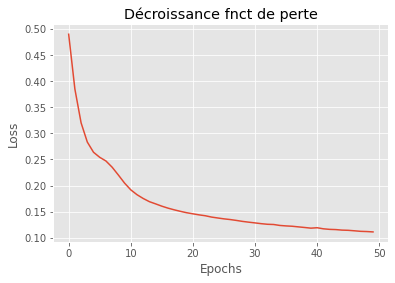

In [317]:
#affichage de l'évolution de l'apprentissage
plt.plot(histori_ae.history['loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Décroissance fnct de perte')
plt.show()

In [185]:
#Utiliastion de l'ae pour prédire dans l'espace initial
ZP = model_ae.predict(df_X_train)
print(ZP)
print(ZP.shape)

[[0.59405804 0.5930751  0.5961418  ... 0.59599954 0.5963218  0.59663457]
 [0.9198724  0.9270458  0.90393484 ... 0.9062385  0.9045312  0.9003666 ]
 [0.16400261 0.15316421 0.1870246  ... 0.1866479  0.19114578 0.19282119]
 ...
 [0.13970968 0.12804154 0.16476858 ... 0.16348094 0.16776589 0.1708817 ]
 [0.914845   0.92195    0.89900595 ... 0.9014605  0.899879   0.8954968 ]
 [0.12902103 0.11724749 0.15416372 ... 0.15332913 0.15794726 0.1604    ]]
(3751, 1776)


In [318]:
#Representation dans l'espace réduit en 2 dimensions
encoder = keras.Model(inputsL,hiddenL) #couche hiddenL représente les 2 neurones au milieu de l'auto-encodeur
coord = encoder.predict(np_scale_X_train)
print(coord)
print(coord.shape)
coord_test = encoder.predict(np_scale_X_test)

#positionnement des individus dans le plan
#fig, axes = plt.subplots(figsize=(15,15))
#axes.set_xlim(0,1)
#axes.set_ylim(0,1)
#étiquettes des points
#for i in range(coord.shape[0]):
 #plt.annotate(df_X_train.index[i],(coord[i,0],coord[i,1]))
#titre et axes
#plt.title('Position des molécules dans le plan')
#plt.xlabel('Coord 1')
#plt.ylabel('Coord 2')
#plt.show()

[[0.6110269  0.6834361 ]
 [0.89853144 0.9101615 ]
 [0.10523587 0.06280133]
 ...
 [0.02872804 0.01525173]
 [0.93588614 0.9424425 ]
 [0.01435751 0.01388612]]
(3751, 2)


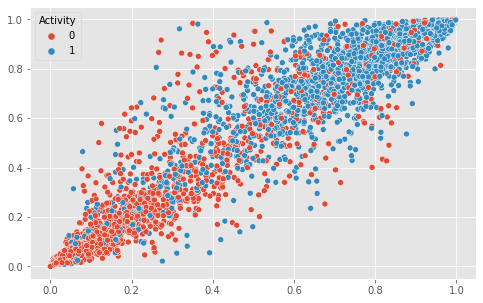

In [319]:
plt.figure(figsize=(8,5))
sns.scatterplot(
    x=coord[:,0], y=coord[:,1],
    hue=df_y_train,
    data=coord,
)

In [272]:
#Decoder 
# This is our encoded (32-dimensional) input
encoded_input = keras.Input(shape=(2,))
# Retrieve the last layer of the autoencoder model
decoder_layer = model_ae.layers[-1]
# Create the decoder model
decoder = keras.Model(encoded_input, decoder_layer(encoded_input))

encoded_data = encoder.predict(df_X_test)
print(encoded_data)
print(encoded_data.shape)

decoded_data = decoder.predict(encoded_data)
print(decoded_data)
print(decoded_data.shape)


[[0.865227   0.9432018 ]
 [0.9690136  0.9694743 ]
 [0.34670037 0.3418088 ]
 ...
 [0.93288815 0.92101586]
 [0.8188983  0.80803275]
 [0.16887465 0.26127848]]
(2501, 2)
[[0.8547844  0.8574081  0.8729231  ... 0.8582846  0.866115   0.84756523]
 [0.9065109  0.9099184  0.92506987 ... 0.90528965 0.91546434 0.8926925 ]
 [0.43482548 0.43253666 0.42239326 ... 0.4359175  0.42905992 0.4440778 ]
 ...
 [0.87499875 0.87805015 0.8910306  ... 0.873247   0.8823569  0.86209774]
 [0.7892823  0.7912945  0.7997579  ... 0.78806424 0.79406685 0.78067696]
 [0.33399606 0.33028883 0.3186928  ... 0.34121364 0.33011463 0.35330892]]
(2501, 1776)


In [193]:
correlations = np.zeros(shape=(1776,2))
for j in range(coord.shape[1]):
  for i in range(np_scale_X_train.shape[1]):
    correlations[i,j]=np.corrcoef(coord[:,j],np_scale_X_train[:,i])[0,1]

dfCorr = pd.DataFrame(correlations,columns=['Corr_1','Corr_2'],index=df_X_train.columns)
print(dfCorr)

         Corr_1    Corr_2
D1    -0.112193 -0.133748
D2     0.142593  0.165977
D3     0.264402  0.260106
D4    -0.056917 -0.068462
D5    -0.221425 -0.217205
...         ...       ...
D1772  0.035856  0.028131
D1773  0.049474  0.047001
D1774  0.029763  0.026671
D1775  0.099140  0.088708
D1776  0.037093  0.032423

[1776 rows x 2 columns]


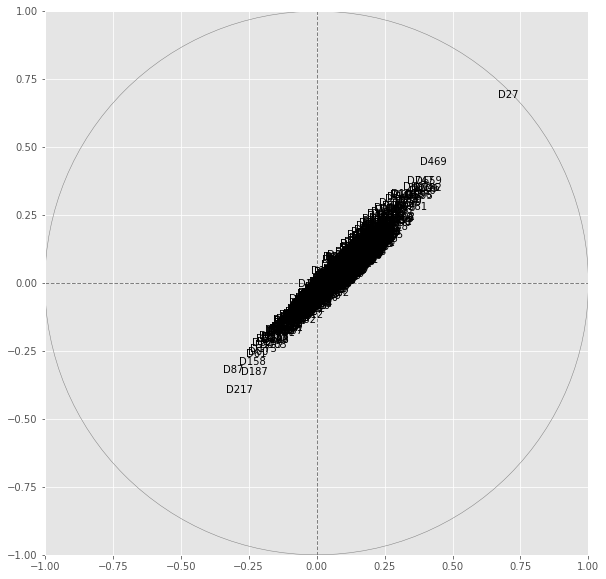

In [194]:
#cercle des corrélations
fig, axes = plt.subplots(figsize=(10,10))
axes.set_xlim(-1.0,1.0)
axes.set_ylim(-1.0,1.0)
#position des variables
for i in range(dfCorr.shape[0]):
  plt.annotate(dfCorr.index[i],(correlations[i,0],correlations[i,1]))
#axes
plt.plot([0,0],[-1,+1],linestyle='--',c='gray',linewidth=1)
plt.plot([-1,+1],[0,0],linestyle='--',c='gray',linewidth=1)
#cosmétique
circle = plt.Circle((0,0),radius=1,fill=False,edgecolor='gray')
axes.add_artist(circle)
axes.set_aspect(1)
plt.show()

In [320]:
#Restitution des données dans l’espace initial
XP = minmax.inverse_transform(ZP)
dp = pd.DataFrame(XP,columns=df_X_train.columns,index=df_X_train.index)
print(df_X_train)
print(dp)

            D1        D2    D3   D4  ...  D1773  D1774  D1775  D1776
0     0.000000  0.497009  0.10  0.0  ...      0      0      0      0
1     0.366667  0.606291  0.05  0.0  ...      0      0      1      0
2     0.033300  0.480124  0.00  0.0  ...      0      0      0      0
3     0.000000  0.538825  0.00  0.5  ...      0      0      0      0
4     0.100000  0.517794  0.00  0.0  ...      0      0      0      0
...        ...       ...   ...  ...  ...    ...    ...    ...    ...
3746  0.033300  0.506409  0.10  0.0  ...      0      0      0      0
3747  0.133333  0.651023  0.15  0.0  ...      1      0      0      0
3748  0.200000  0.520564  0.00  0.0  ...      0      0      0      0
3749  0.100000  0.765646  0.00  0.0  ...      0      0      0      0
3750  0.133333  0.533952  0.00  0.0  ...      0      0      0      0

[3751 rows x 1776 columns]
            D1        D2        D3  ...     D1774     D1775     D1776
0     0.594058  0.686755  0.566335  ...  0.596000  0.596322  0.596635
1   

### Modèle à partir de la data décodée par l'auto-encodeur

In [353]:
#Input of the model
input_shape = (2,) #1776 descriptors
inputs = keras.Input(shape=input_shape)
print(inputs.shape)
print(inputs.dtype)
#drop_out_1 = layers.Dropout(0.2)(inputs)
#Model layers
hidden1 = layers.Dense(64, activation="relu")(inputs)
hidden2 = layers.Dense(32, activation="relu")(hidden1)

#hidden3 = layers.Dense(64, activation="relu")(hidden2), 3755 1 hidden
outputs = layers.Dense(1, activation ="sigmoid")(hidden2) #shape = 1 -> One value between 0 and 1 (regression)
model_after_ae = keras.Model(inputs=inputs, outputs=outputs,name="bioresponse_model")
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
#Compile model
#Binary Cross-Entropy specifies that the model should optimize the log loss
model_after_ae.compile(
    #loss=keras.losses.MeanSquaredError(),
    loss=tf.keras.losses.BinaryCrossentropy(), #Evaluate the model with the log loss 
    optimizer=keras.optimizers.SGD(learning_rate=0.01), #ou Adagrad avec haut LR
    #metrics=[soft_acc] #Compute accuracy for a regression model
    metrics=["accuracy"]
)

(None, 2)
<dtype: 'float32'>


In [354]:
histori_after_ae=model_after_ae.fit(coord,df_y_train, batch_size=75, epochs= 100, validation_split=0.2, callbacks=[callback])

Epoch 1/100
40/40 [==============================] - 1s 6ms/step - loss: 0.6971 - accuracy: 0.4177 - val_loss: 0.6766 - val_accuracy: 0.5366
Epoch 2/100
40/40 [==============================] - 0s 2ms/step - loss: 0.6533 - accuracy: 0.5437 - val_loss: 0.6492 - val_accuracy: 0.5366
Epoch 3/100
40/40 [==============================] - 0s 2ms/step - loss: 0.6254 - accuracy: 0.5850 - val_loss: 0.6328 - val_accuracy: 0.6298
Epoch 4/100
40/40 [==============================] - 0s 2ms/step - loss: 0.6034 - accuracy: 0.6777 - val_loss: 0.6173 - val_accuracy: 0.6951
Epoch 5/100
40/40 [==============================] - 0s 2ms/step - loss: 0.5842 - accuracy: 0.7420 - val_loss: 0.6050 - val_accuracy: 0.7284
Epoch 6/100
40/40 [==============================] - 0s 3ms/step - loss: 0.5674 - accuracy: 0.7757 - val_loss: 0.5937 - val_accuracy: 0.7390
Epoch 7/100
40/40 [==============================] - 0s 2ms/step - loss: 0.5513 - accuracy: 0.7980 - val_loss: 0.5831 - val_accuracy: 0.7483
Epoch 8/100
4

In [355]:
#Test the model
loss, acc = model_after_ae.evaluate(coord_test, df_y_test, verbose=1)
print(loss) #1.25 loss : résultats du modele FC entrainé à partir des données restituées par l'auto encodeur

79/79 [==============================] - 0s 2ms/step - loss: 0.6015 - accuracy: 0.0000e+00
0.6015266180038452


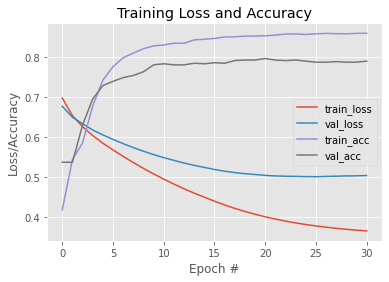

In [356]:
# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(histori_after_ae.history["loss"], label="train_loss")
plt.plot(histori_after_ae.history["val_loss"], label="val_loss")
plt.plot(histori_after_ae.history["accuracy"], label="train_acc")
plt.plot(histori_after_ae.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

In [360]:
prediction = model_after_ae.predict(coord_test)
print(pd.DataFrame(prediction).describe())

                 0
count  2501.000000
mean      0.571640
std       0.322708
min       0.150059
25%       0.184280
50%       0.652910
75%       0.894470
max       0.958275


SHapley Additive exPlanations (SHAP) du modèle

In [361]:
#SHAP https://www.yourdatateacher.com/2021/05/17/how-to-explain-neural-networks-using-shap/
!pip install shap
import shap

     |████████████████████████████████| 371 kB 5.2 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for shap: filename=shap-0.40.0-cp37-cp37m-linux_x86_64.whl size=509229 sha256=50353566c93e143ea3f3503479629515079f31d2b82af238d93bb18af84f0996
  Stored in directory: /root/.cache/pip/wheels/ec/35/84/e304841ac4b910bc95fe9a6e5302eb2507b4333728851dcbfb
Successfully built shap


In [ ]:
sample = shap.sample(df_X_train,5)
explainer = shap.KernelExplainer(model.predict,sample)
shap_values = explainer.shap_values(df_X_test,nsamples=50)

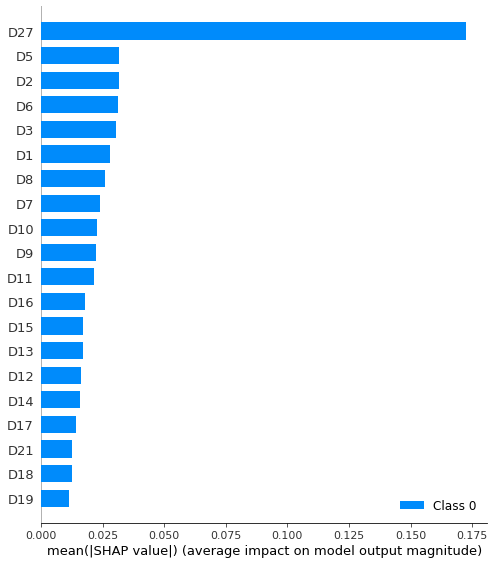

In [ ]:
shap.summary_plot(shap_values, X_test)
shap.summary_plot(shap_values,df_X_test,feature_names=df_X_test.columns)

In [ ]:
shap.summary_plot(shap_values[1], df_X_test)

NameError: ignored

In [ ]:
#dropout améliore pas
#KNN, EDA, SVM , SHAP, MDS, 

# KNN Regressor

In [ ]:
#KNN https://realpython.com/knn-python/#using-scikit-learn-to-inspect-model-fit
#Regression based on k-nearest neighbors.
#The target is predicted by local interpolation of the targets associated of the nearest neighbors in the training set.
from sklearn.neighbors import KNeighborsRegressor
parameters = {"n_neighbors": range(1, 10)}
gridsearch = GridSearchCV(KNeighborsRegressor(), parameters)
gridsearch.fit(df_X_train, df_y_train)
print(gridsearch.best_params_)#best params = 7

In [134]:
from sklearn.neighbors import KNeighborsRegressor
knn_model = KNeighborsRegressor(n_neighbors=7,weights='uniform', algorithm = 'auto')#-> meme resultats qqsoit les param du knn, log_loss = 1.6
#To get the data into the model, you can then fit the model on the training dataset
knn_model.fit(data_X_train, data_y_train)

train_preds = knn_model.predict(data_X_train)
train_loss =  log_loss(data_y_train, train_preds)
print(train_loss)

test_preds = knn_model.predict(data_X_valid)
test_loss =  log_loss(data_y_valid, test_preds) #environ 1.6
print(test_loss) #1.84 avec 5 voisins, 1.11 avec 7 voisins

0.39058301879127105
2.0406025895420936


In [ ]:
#from sklearn.metrics import classification_report, confusion_matrix
#print(confusion_matrix(data_y_train, train_preds))
#print(classification_report(data_y_train, train_preds))

#SVR 

In [123]:
#SVM -> SVR pour régression
#https://scikit-learn.org/stable/modules/svm.html#regression
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR

regr = SVR(C=1.0, epsilon=0.2,gamma='scale', kernel='rbf')
regr.fit(data_X_train, data_y_train)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.2, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [ ]:
#GridSearch
#parameters = [{'kernel': ['poly', 'rbf', 'sigmoid'], 'gamma': ['scale', 'auto'],
                     #'C': [1, 10]}, {'kernel': ['linear'], 'C': [1, 10]}]
parameters = {'kernel': ['poly', 'rbf', 'sigmoid'], 'gamma': ['scale', 'auto'],'C': [1, 10]}
gridsearch_svr = GridSearchCV(SVR(), parameters)
gridsearch_svr.fit(data_X_train, data_y_train)

print(gridsearch_svr.best_params_) #SVR(C=1.0, epsilon=0.2,gamma='scale', kernel='rbf'))

In [129]:
svm_train = regr.predict(data_X_train)
svm_train_loss =  log_loss(data_y_train, svm_train)
print(svm_train_loss)

svm_test = regr.predict(data_X_valid)
svm_test_loss =  log_loss(data_y_valid, svm_test)
print(pd.DataFrame(svm_test.describe())
print(svm_test_loss) #Loss = 0.51

0.3173133398439126
                0
count  751.000000
mean     0.549586
std      0.289612
min     -0.144893
25%      0.267279
50%      0.620716
75%      0.799530
max      1.163736
0.5233427726948298


# MLP Regressor

In [ ]:
from sklearn.neural_network import MLPRegressor
nn = MLPRegressor(solver='sgd', alpha=1e-1, hidden_layer_sizes=(5, 2), random_state=0, max_iter=500)
nn.fit(data_X_train, data_y_train)
X_train_summary = shap.kmeans(data_X_train, 3)
nn_train = nn.predict(data_X_train)
nn_test = nn.predict(data_X_valid)

nn_train_loss = log_loss(data_y_train, nn_train)
nn_test_loss = log_loss(data_y_valid, nn_test)
print(nn_train_loss)
print(nn_test_loss)

0.43959330105981476
0.6435128658184228


SHAP du MLP Regressor

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html


  0%|          | 0/751 [00:00<?, ?it/s]

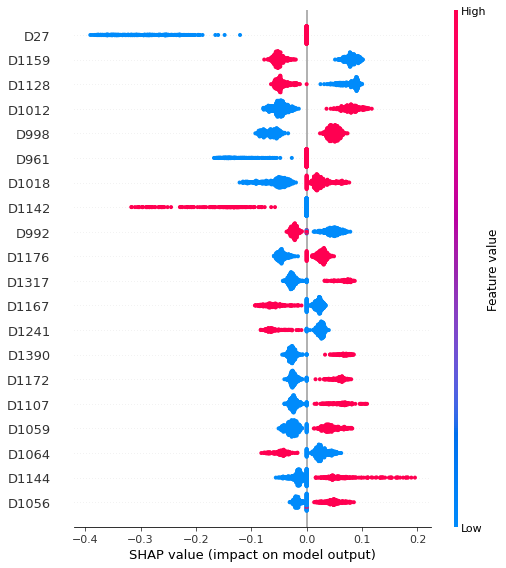

In [ ]:
# explain all the predictions in the test set
explainer = shap.KernelExplainer(nn.predict, X_train_summary)
shap_values = explainer.shap_values(data_X_valid)
shap.summary_plot(shap_values, data_X_valid)

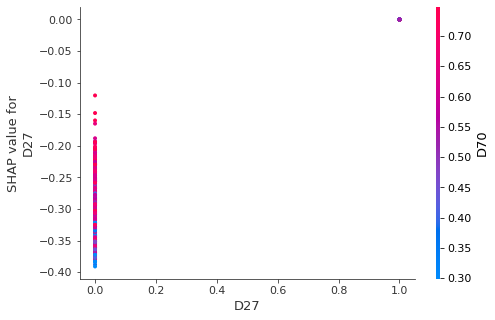

In [ ]:
shap.dependence_plot("D27", shap_values, data_X_valid)